Taille de l'ensemble d'entraînement : 13976
Taille de l'ensemble de test : 5991
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  17.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  17.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  16.9s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  17.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  17.6s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  15.7s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  15.2s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  15.5s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  15.7s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  15.5s
[CV] END ......................C=0.1, gamma=0.01,

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


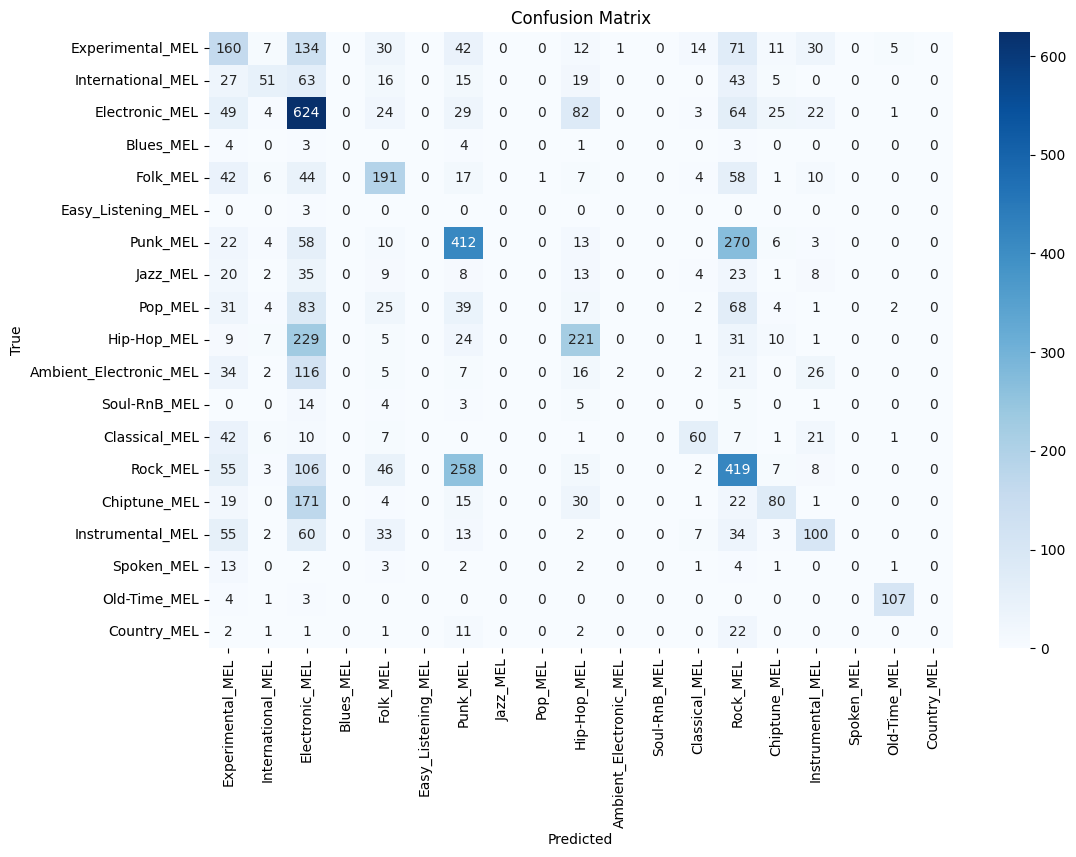

In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# **Étape 1 : Charger les données**
def load_data(data_dir, image_size=(128, 128)):
    """
    Charge les PNG et les étiquettes correspondantes.
    Args:
        data_dir (str): Chemin vers le répertoire contenant les classes.
        image_size (tuple): Taille à laquelle redimensionner les images.
    Returns:
        X, y: Images vectorisées et labels.
    """
    X = []
    y = []
    classes = os.listdir(data_dir)  # Liste des classes
    classes.remove("Unknown_MEL")
    for label, genre in enumerate(classes):
        genre_dir = os.path.join(data_dir, genre)
        for file in os.listdir(genre_dir):
            if file.endswith('.png'):
                file_path = os.path.join(genre_dir, file)
                img = Image.open(file_path).convert('L')  # Convertir en niveaux de gris
                img = img.resize(image_size)  # Redimensionner
                X.append(np.array(img).flatten())  # Aplatir l'image
                y.append(label)
    return np.array(X), np.array(y), classes

# Charger les données
data_dir = "/kaggle/input/music-genres/Music_Mel"  # Remplacez par votre chemin

X, y, classes = load_data(data_dir)

# **Étape 2 : Normalisation des données**
# Normaliser les valeurs des pixels entre 0 et 1
X = X / 255.0

# **Étape 3 : Réduction de dimension avec PCA (optionnel)**
# Réduire les dimensions à 100 composants
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)

# **Étape 4 : Division des ensembles (train, val, test)**
# Division en train (70%), validation (15%), test (15%)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Vérification des tailles
print(f"Taille de l'ensemble d'entraînement : {len(X_train)}")
print(f"Taille de l'ensemble de test : {len(X_test)}")

# **Étape 5 : Optimisation des hyperparamètres avec GridSearchCV**
# Définir l'espace de recherche pour les hyperparamètres
param_grid = {
    'C': [0.1, 1],           # Différents niveaux de régularisation
    'gamma': ['scale', 0.01, 0.1, 1], # Échelles différentes pour RBF
    'kernel': ['rbf', 'linear']       # Test des noyaux RBF et linéaire
}

# Configurer GridSearchCV avec 5-fold cross-validation
svm = SVC()
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='accuracy', cv=5, verbose=2)

# Exécuter la recherche sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Résultats de la recherche
print("\nMeilleurs paramètres :", grid_search.best_params_)
print("Meilleure précision de validation croisée :", grid_search.best_score_)

# **Étape 6 : Évaluation finale sur l'ensemble de test**
# Utiliser le meilleur modèle pour prédire sur l'ensemble de test
best_svm = grid_search.best_estimator_
y_test_pred = best_svm.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Affichage des résultats
print(f"\nPrécision finale sur l'ensemble de test : {test_accuracy:.2f}")
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred, target_names=classes))

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
